In [1]:
# 导入必要库
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 设置风格，让图表更有现代感
sns.set_style("whitegrid")

# 设置图表显示中文
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False    # 用来正常显示负号

# 1. 获取数据 
try:
    data1 = pd.read_excel('商品销售数据.xlsx', sheet_name='信息表')
    data2 = pd.read_excel('商品销售数据.xlsx', sheet_name='销售数据表')
    print("数据读取成功！")
    # 打印前几行
    print(data1.head())
    print(data2.head())
except FileNotFoundError:
    print("❌ 错误：找不到文件，请确认文件名是否为 '商品销售数据.xlsx'")

# 2. 数据合并 
# 根据“商品编号”列合并两个表，保留销售数据表的所有记录
# how='right' 表示以 data2 为主
df = pd.merge(data1, data2, on='商品编号', how='right')

# 3. 数据计算与处理 
# 3.1 计算销售金额 = 商品销售价 * 订单数量
df['销售金额'] = df['商品销售价'] * df['订单数量']

# 3.2 提取月份和星期
df['订单日期'] = pd.to_datetime(df['订单日期'])
df['月份'] = df['订单日期'].dt.month

df['星期'] = df['订单日期'].dt.day_name()
# 设置星期的顺序（可选，为了画图按周一到周日排列）
week_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df['星期'] = pd.Categorical(df['星期'], categories=week_order, ordered=True)

# 4. 统计分析：每月销售金额 
# 按照 '月份' 分组，对 '销售金额' 求和
month_sales_print = df.groupby('月份')['销售金额'].sum()
print("每月销售统计结果：")
print(month_sales_print)


数据读取成功！
   商品大类 商品小类    商品名称   商品编号  商品销售价
0  运动上装   背心    瑜伽背心  bx001     48
1  运动上装   背心  跑步运动背心  bx002     39
2  运动上装   背心  纯色简约背心  bx003     36
3  运动上装   背心  轻薄透气背心  bx004     49
4  运动上装   背心  修身运动背心  bx005     50
        订单日期          订单编号   商品编号  订单数量
0 2022-01-01  HS2022000001  fd003    26
1 2022-01-01  HS2022000002  fd004    28
2 2022-01-01  HS2022000003  sh001    20
3 2022-01-01  HS2022000004  sh003    35
4 2022-01-01  HS2022000005  bx002    60
每月销售统计结果：
月份
1     344878.0
2     375111.0
3     431575.0
4     408359.0
5     463358.0
6     424416.0
7     490090.0
8     468356.0
9     433489.0
10    485727.0
11    484643.0
12    470306.0
Name: 销售金额, dtype: float64


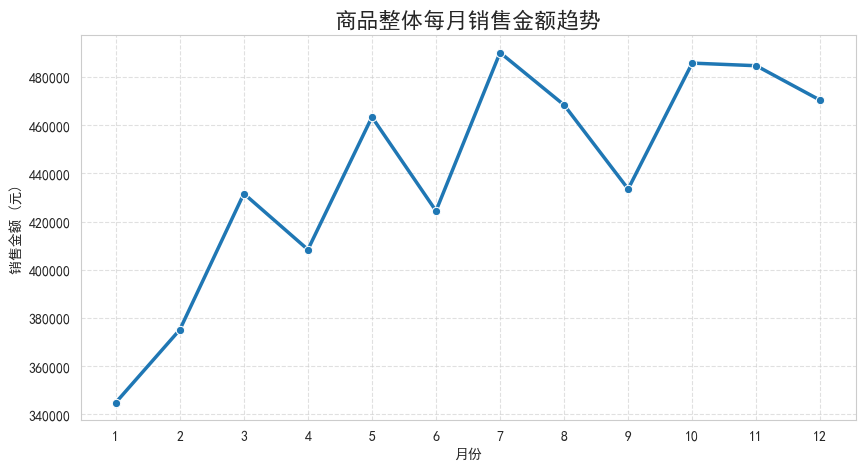

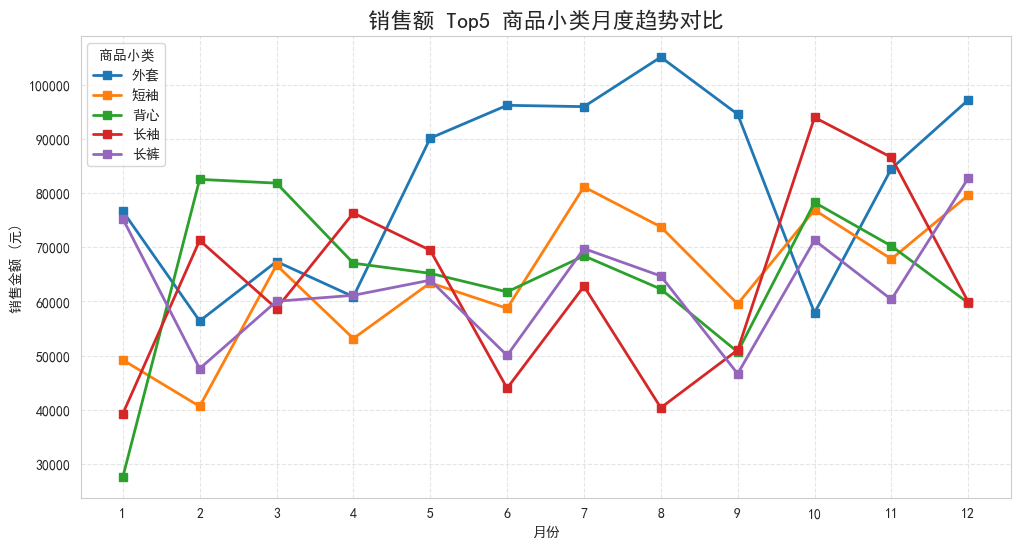

In [2]:
# 可视化任务
# 任务一：分析商品每月销售变化趋势 (基础要求 - 折线图)

plt.figure(figsize=(10, 5))
monthly_sales = df.groupby('月份')['销售金额'].sum()

# 使用 seaborn 绘制带标记的折线图
sns.lineplot(x=monthly_sales.index, y=monthly_sales.values, marker='o', linewidth=2.5, color='#1f77b4')

plt.title('商品整体每月销售金额趋势', fontsize=16, fontweight='bold')
plt.ylabel('销售金额 (元)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(range(1, 13))
plt.show()

# 任务二：分析“小类商品”每月销售变化趋势 (基础要求 - 进阶版)
# 为了展示清晰，选出销售额前 5 名的小类来画折线，其他的归为“其他”。

# 1. 统计各小类总销售额，找前5名
top_categories = df.groupby('商品小类')['销售金额'].sum().nlargest(5).index.tolist()

# 2. 筛选数据
df_top = df[df['商品小类'].isin(top_categories)]
pivot_small_cat = df_top.groupby(['月份', '商品小类'])['销售金额'].sum().unstack()

# 3. 绘图
pivot_small_cat.plot(kind='line', marker='s', figsize=(12, 6), linewidth=2)
plt.title('销售额 Top5 商品小类月度趋势对比', fontsize=16, fontweight='bold')
plt.ylabel('销售金额 (元)')
plt.legend(title='商品小类')
plt.xticks(range(1, 13))
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


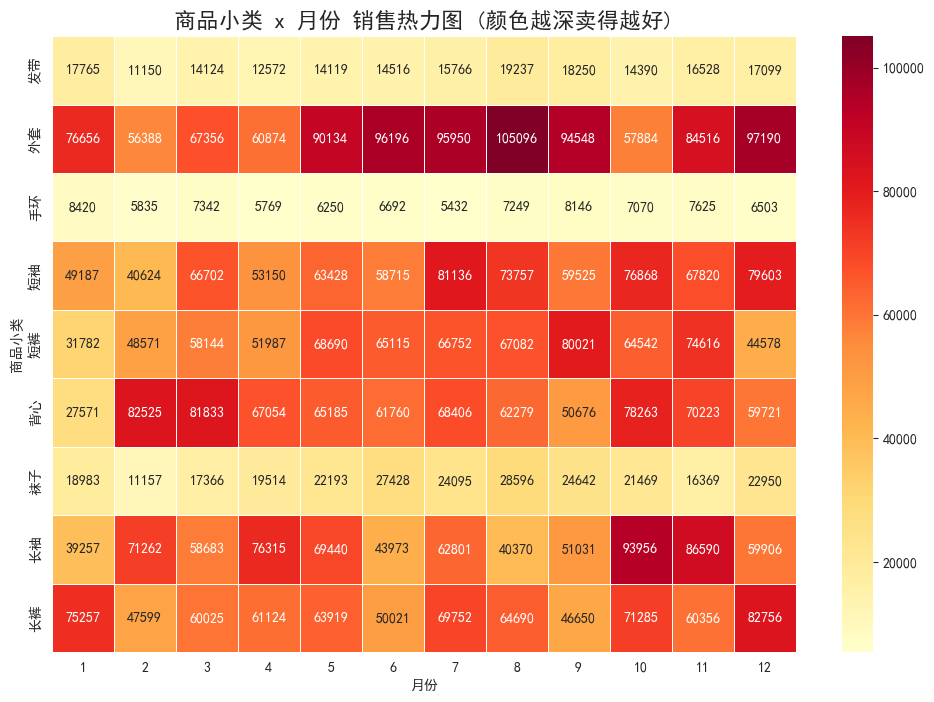

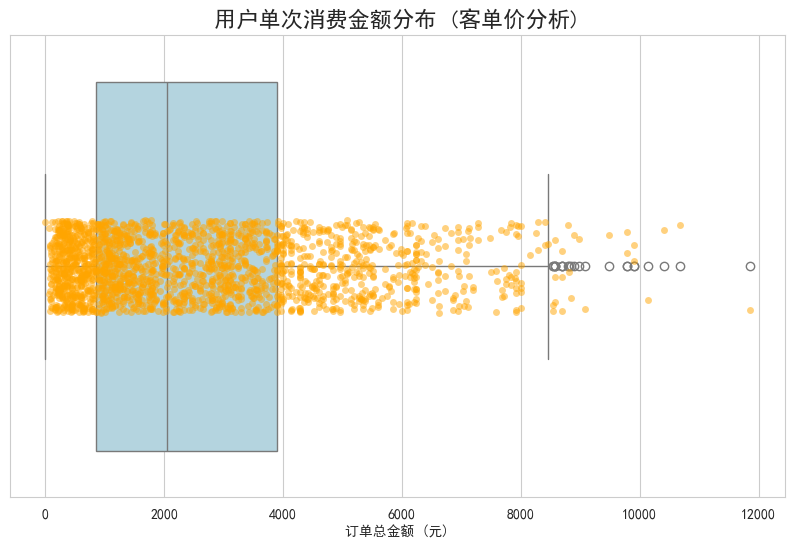

分析结论：用户的平均客单价约为 2588.39 元。


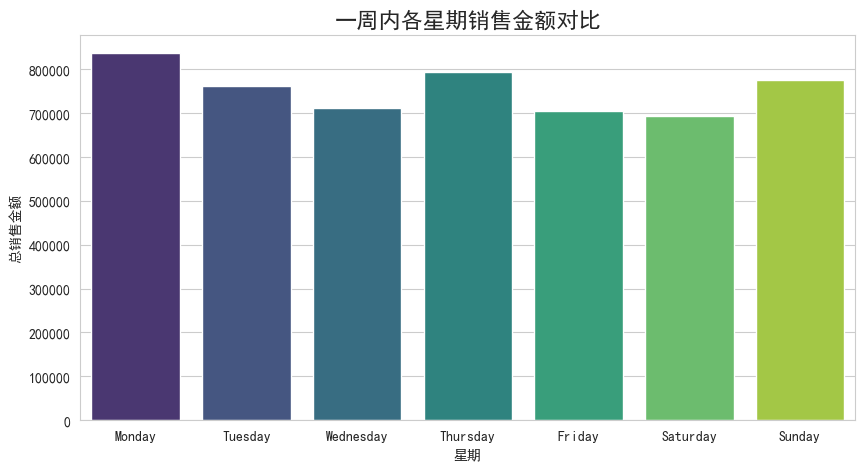

In [3]:
# 拓展 1：商品小类热力图 
# 能一眼看出哪个品类在几月份是爆款，非常直观！
plt.figure(figsize=(12, 8))

# 行是小类，列是月份，值是销售额
heatmap_data = df.groupby(['商品小类', '月份'])['销售金额'].sum().unstack().fillna(0)

# 绘图
sns.heatmap(heatmap_data, cmap='YlOrRd', annot=True, fmt='.0f', linewidths=0.5)
plt.title('商品小类 x 月份 销售热力图 (颜色越深卖得越好)', fontsize=16)
plt.show()

# 拓展 2：客单价分布分析 (箱线图) ——分析“订单编号”。
# 每一个订单编号代表一次“消费行为”。
# 计算每个订单的总金额
order_amounts = df.groupby('订单编号')['销售金额'].sum()

plt.figure(figsize=(10, 6))
# 绘制箱线图和散点图的结合，展示订单金额分布
sns.boxplot(x=order_amounts, color='lightblue')
sns.stripplot(x=order_amounts, color='orange', alpha=0.5) # 把具体的点也画出来

plt.title('用户单次消费金额分布 (客单价分析)', fontsize=16)
plt.xlabel('订单总金额 (元)')
plt.show()

print(f"分析结论：用户的平均客单价约为 {order_amounts.mean():.2f} 元。")
# 可以在 README 中写：大多数订单集中在 x元 到 y元 之间，建议针对此区间制定满减策略。

# 拓展 3：星期销售分析 (决策支持)
# 分析一周中哪天生意最好
weekday_sales = df.groupby('星期')['销售金额'].sum()

plt.figure(figsize=(10, 5))
sns.barplot(x=weekday_sales.index, y=weekday_sales.values, hue=weekday_sales.index, palette='viridis', legend=False)

plt.title('一周内各星期销售金额对比', fontsize=16)
plt.ylabel('总销售金额')
plt.show()
